In [183]:
import pandas as pd
import numpy as np
import opendatasets
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from custom_transformers import SelectLowCorrelationFeatures
import joblib

In [184]:
# run only once to download the data, make sure the kaggle.json file is in the same folder of your ipynb notebook
# opendatasets.download(
#     dataset_id_or_url='https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques',
#     data_dir='..'
# )
# os.rename('../house-prices-advanced-regression-techniques', '../data')

In [185]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [186]:
train.shape

(1460, 81)

In [187]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [188]:
x = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [189]:
RANDOM_STATE = 42

ohe_cols = [
    'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', #'Neighborhood'    not sure i wanna use neighborhood, to many values
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
    'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'
]

oe_cols = [
    'LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu',
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
    'PoolQC', 'Fence'
]

oe_values = [
    ['IR3', 'IR2', 'IR1', 'Regular'],  # LotShape
    ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Utilities
    ['Sev', 'Mod', 'Gtl'],  # LandSlope
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # ExterCond
    ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # BsmtQual
    ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # BsmtCond
    ['No Feature', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['No Feature', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
    ['No Feature', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # HeatingQc
    ['No', 'Yes'],  # CentralAir
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # KitchenQual
    ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Functional
    ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # FireplaceQu
    ['No Feature', 'Unf', 'RFn', 'Fin'],  # GarageFinish
    ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # GarageQual
    ['No Feature', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # GarageCond
    ['N', 'P', 'Y'],  # PavedDrive
    ['No Feature', 'Fa', 'TA', 'Gd', 'Ex'],  #PoolQC
    ['No Feature', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],  # Fence
]

# cat_cols = x.select_dtypes(include='object').columns.tolist()
num_cols = x.select_dtypes(include='number').columns.tolist()[1:]

In [191]:
def pipe_func(ohe_cols, oe_cols, oe_values, num_cols, transform_target=None):
    
    cat_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No Feature')
    num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    ohe = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=0.2, sparse_output=False)
    oe = OrdinalEncoder(categories=oe_values, handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1, min_frequency=0.2)
    scaler = StandardScaler()
    # regressor = GradientBoostingRegressor(max_depth=5, n_estimators=300,random_state=RANDOM_STATE)  # best model and hyperparameters found before
    regressor = LinearRegression()
    pca = PCA(n_components=50, random_state=RANDOM_STATE)  # best n_components for pca found before
    transform_target = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

    ohe_pipe = Pipeline(
        steps=[
            ('imputer_ohe', cat_imputer),
            ('ohe', ohe)

        ]
    )

    oe_pipe = Pipeline(
        steps=[
            ('imputer_oe', cat_imputer),
            ('oe', oe)
        ]
    )

    num_pipe = Pipeline(
        steps=[
            ('numerical_imputer', num_imputer),
            ('scaler', scaler),
            ('transf', 'passthrough')
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('one_hot_encoders', ohe_pipe, ohe_cols),
            ('ordinal_encoders', oe_pipe, oe_cols),
            ('num_scaler', num_pipe, num_cols)

        ],
        sparse_threshold=0
    )

    target_trans = TransformedTargetRegressor(
        regressor=regressor,
        transformer=transform_target
    )
    
    full_pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('dim_reduction', pca),
            ('regressor', target_trans)
        ]
    )
    
    return full_pipeline

# building the scorer function
def rmse_of_log(y_true, y_pred):
    """
    This scorer function will calculate the RMSE of the log of predictions and true values
    """
    return root_mean_squared_error(np.log1p(y_true), np.log1p(y_pred))

In [ ]:
# %%capture
pipe_model = pipe_func(ohe_cols=ohe_cols, oe_cols=oe_cols, oe_values=oe_values, num_cols=num_cols)

param_grid = {
    'regressor__transformer': [
        None, 
        FunctionTransformer(func=np.log1p, inverse_func=np.expm1), 
        FunctionTransformer(func=np.sqrt, inverse_func=np.square),
        PowerTransformer(method='box-cox'),
        PowerTransformer(method='yeo-johnson'),
    ],
    'dim_reduction__n_components': [30, 50, 80, 110],
    'preprocessor__num_scaler__transf': [
        # None, 
        # FunctionTransformer(func=np.log1p, inverse_func=np.expm1), 
        # FunctionTransformer(func=np.sqrt, inverse_func=np.square),
        # PowerTransformer(method='box-cox'),
        # PowerTransformer(method='yeo-johnson'),
        SelectLowCorrelationFeatures(threshold_target_corr=0.6, threshold_feature_corr=0.2)
    ]
}

rmse_log_scorer= make_scorer(rmse_of_log, greater_is_better=False)

grid_search = GridSearchCV(pipe_model, param_grid, cv=5, scoring=rmse_log_scorer, verbose=3)

# Fit GridSearchCV to your data
grid_search.fit(X=x, y=y)

In [198]:
results = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score', ascending=True).head(10)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reduction__n_components,param_preprocessor__num_scaler__transf,param_regressor__transformer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.141877,0.015017,0.018989,0.006846,50,SelectLowCorrelationFeatures(threshold_feature...,"FunctionTransformer(func=<ufunc 'log1p'>, inve...","{'dim_reduction__n_components': 50, 'preproces...",-0.129397,-0.159914,-0.143434,-0.153859,-0.185697,-0.154460,0.018738,1
8,0.135510,0.005482,0.017931,0.002543,50,SelectLowCorrelationFeatures(threshold_feature...,PowerTransformer(method='box-cox'),"{'dim_reduction__n_components': 50, 'preproces...",-0.130046,-0.162936,-0.143350,-0.154164,-0.186329,-0.155365,0.018989,2
9,0.140009,0.009427,0.017798,0.002087,50,SelectLowCorrelationFeatures(threshold_feature...,PowerTransformer(),"{'dim_reduction__n_components': 50, 'preproces...",-0.130046,-0.162936,-0.143350,-0.154164,-0.186329,-0.155365,0.018989,3
1,0.141032,0.018457,0.018651,0.006879,30,SelectLowCorrelationFeatures(threshold_feature...,"FunctionTransformer(func=<ufunc 'log1p'>, inve...","{'dim_reduction__n_components': 30, 'preproces...",-0.134373,-0.165128,-0.138585,-0.157364,-0.186857,-0.156462,0.019012,4
7,0.138798,0.005821,0.015213,0.006379,50,SelectLowCorrelationFeatures(threshold_feature...,"FunctionTransformer(func=<ufunc 'sqrt'>, inver...","{'dim_reduction__n_components': 50, 'preproces...",-0.133119,-0.154688,-0.149315,-0.159661,-0.186784,-0.156713,0.017484,5
3,0.145481,0.012072,0.017868,0.006099,30,SelectLowCorrelationFeatures(threshold_feature...,PowerTransformer(method='box-cox'),"{'dim_reduction__n_components': 30, 'preproces...",-0.134741,-0.168667,-0.138634,-0.157948,-0.187345,-0.157467,0.019440,6
4,0.141022,0.011916,0.019715,0.007925,30,SelectLowCorrelationFeatures(threshold_feature...,PowerTransformer(),"{'dim_reduction__n_components': 30, 'preproces...",-0.134741,-0.168667,-0.138634,-0.157948,-0.187346,-0.157467,0.019440,7
2,0.134796,0.018145,0.011611,0.005582,30,SelectLowCorrelationFeatures(threshold_feature...,"FunctionTransformer(func=<ufunc 'sqrt'>, inver...","{'dim_reduction__n_components': 30, 'preproces...",-0.139250,-0.158925,-0.143221,-0.161964,-0.189449,-0.158562,0.017743,8
5,0.139664,0.009386,0.019023,0.003249,50,SelectLowCorrelationFeatures(threshold_feature...,None,"{'dim_reduction__n_components': 50, 'preproces...",-0.160924,-0.162891,-0.168627,-0.225453,-0.215565,-0.186692,0.027903,9
0,0.140816,0.013641,0.016119,0.000668,30,SelectLowCorrelationFeatures(threshold_feature...,None,"{'dim_reduction__n_components': 30, 'preproces...",-0.165694,-0.168490,-0.162822,-0.224482,-0.212174,-0.186732,0.026151,10


In [199]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'dim_reduction__n_components': 50, 'preprocessor__num_scaler__transf': SelectLowCorrelationFeatures(threshold_feature_corr=0.2,
                             threshold_target_corr=0.6), 'regressor__transformer': FunctionTransformer(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>)}
-0.15446019721661153


<Axes: xlabel='SalePrice', ylabel='SalePrice'>

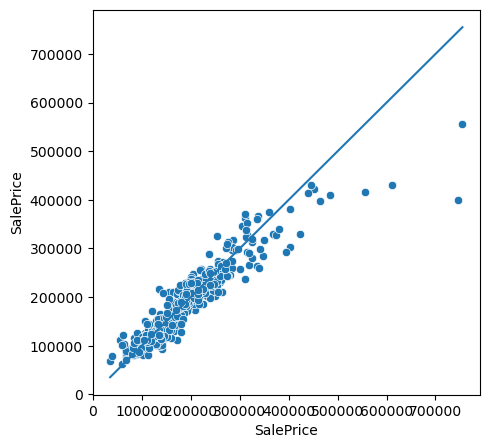

In [196]:
best_model = grid_search.best_estimator_
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=RANDOM_STATE)

best_model.fit(X=x_train, y=y_train)

predictions = best_model.predict(X=x_test)

fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(x=y_test, y=predictions, ax=ax)
sns.lineplot(x=y_test, y=y_test)

In [197]:
# joblib.dump(grid_search, '../models/feat_select_transf_taget_transf_pipeline_gbr.pkl')